<a href="https://colab.research.google.com/github/Sandeep0076/Project/blob/master/Document_CLustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Document** **Clustering**</center>



## **Objective** :

In the project, I am using a dataset which contains thousands of articles about the darkweb. To understand what is inside those articles, what kind of topics people are discussing, I will do the following things.


1.   I will use a machine learning algorithm and try to group similar kinds of articles. As an outcome of which lets say we will have 10 different groups of articles. Each group of articles will represent similar content/context. The number of articles in each group may vary.

2. After grouping similar kinds of articles. I will extract a summary of each group. If we have 10 groups, then we will have 10 extractive summaries. In this way rather than just one single summary of a dataset we will have a whole general idea about the articles.

1.   Along with the summary, I will extract the most relevant keywords which were discussed in those groups.








## Import file

In [ ]:
from google.colab import drive
drive.mount("/content/Gdrive")

Drive already mounted at /content/Gdrive; to attempt to forcibly remount, call drive.mount("/content/Gdrive", force_remount=True).


## Import Packages

In [ ]:
import pandas as pd
import re
import urllib, os, time, tarfile
from collections import defaultdict
from pprint import pprint
import string
from gensim.utils import tokenize
from gensim.models.phrases import Phrases, Phraser
!pip install ipdb -q
import ipdb
from gensim.models import LdaModel, CoherenceModel
from matplotlib.pyplot import plot as plt

## Text preprocessing

In [ ]:
#Importing dataset from google drive
df = pd.read_csv(r'/content/Gdrive/My Drive/clean_with_dup1.csv')

In [ ]:
#cleaning text / removing unwanted words or symbols inside the articles for efficient outcome
df = df[['clean_body']]
def clean_data(text):
    text = (str(text).lower())
    text = re.sub("[^a-zA-ZäöüÄÖÜß]+", " ", text)
    return text

df['clean_text'] = df.clean_body.apply(clean_data)
df = df[['clean_text']]
df = df.rename(columns={'clean_text': 'text'})
df.head()

,text
0,koblenzmainzrüsselsheim die kripo koblenz fahn...
1,koblenzmainzrüsselsheim die kripo koblenz fahn...
2,giessen das böse ist immer und überall wusste ...
3,giessen das böse ist immer und überall wusste ...
4,der zweikampf versprach ein feuerwerk anonymou...


In [ ]:
# Counting the words inside each document
df['word_count'] = df['text'].apply(lambda x: len(x.strip().split()))  # word count in abstract

In [ ]:
df.describe(include='all')

In [ ]:
#deleting duplicate articles
df.drop_duplicates(['text'], inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,text,word_count
0,koblenzmainzrüsselsheim die kripo koblenz fahn...,414
2,giessen das böse ist immer und überall wusste ...,547
4,der zweikampf versprach ein feuerwerk anonymou...,779
5,berlin dpa afx im netz sind erneut mehrere hun...,310
6,würzburg dpalby im prozess wegen schweren sexu...,220


## Checking Languages

This dataset contains majority of the articles in German language, however there are few articles in other languages also which if included will produce inaccurate grouping of the articles. So I am cheacking the language used and removing them. 

In [ ]:
from tqdm import tqdm
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in (range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [ ]:
# As we can see there are artciles in English, Italien, French, German etc.
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
print(languages_dict)

{'af': 2, 'da': 1, 'de': 13024, 'fr': 18, 'sv': 1, 'it': 4, 'en': 133, 'nl': 3}


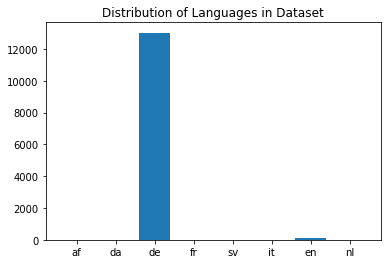

In [ ]:
# This plot shows the distribution of the articles in different languages.
import matplotlib.pyplot as plt
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


In [ ]:
# Keeping only articles in German language.
df = df[df['language'] == 'de'] 

### Stop words

There are words inside the aricles for example, and, but , how, what etc which carry very little useful information. So by removing them, the algorith produces better results.

In [ ]:
## Stopwords for German Language
url = 'https://raw.githubusercontent.com/solariz/german_stopwords/master/german_stopwords_full.txt'
filename = url.rsplit('/', 1)[-1]
datadir = '/content/'
urllib.request.urlretrieve(url, datadir + 'stopwords-de.txt')

## Parsing text :
Converting text into tokens for using them as an input to the algorithm


In [ ]:
!pip install spacy
!python -m spacy download de_core_news_sm
import spacy
import de_core_news_sm
parser = de_core_news_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

In [ ]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

### Load stop Words

In [ ]:
stopwords_filename = '/content/stopwords-de.txt'

with open(stopwords_filename) as f:
    stopwords = [line for line in f.read().splitlines() if not line.startswith(';')]

In [ ]:
# add more stopwords
more_stopwords = 'anbelangt unter anderem beispiel dingen genauso gerne hierzu hinzu liebe nahezu nunmehr punkt relativ sodass sozusagen trotz übrigen vielfach vielfache vielmehr voraussichtlich wahrlich wahrscheinlich zuvor'
stopwords.extend(more_stopwords.split())
stopwordsdict = dict.fromkeys(stopwords, 1)

print(len(stopwordsdict), "stopwords")

1876 stopwords


In [ ]:
df["processed_text"] = df["text"].apply(spacy_tokenizer)

### Vectorization

Now that I have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose I will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

Term Frequency = No. of repetitive words in a sentence/no. of words in a sentence.
Inverse Document frequency = log(no. of sentences/ no. of sentences containing that word)
Normally in bag of words every word has same value , good =1 boy = 1 , but tfIDf will give more semantic meaning by giving good = o, and boy some log(..)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    # check this latter that its is for one sentence or whgole dataset 
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

I will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [ ]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)#vectorize(text, maxx_features)
X.shape

(13024, 4096)

## PCA & Clustering

As we see the output of the text is a very big matrix (13024, 4096).  We need to reduce the dimentions so that the machine can handle the load.
I will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but  will remove some noise/outliers from the data, and make the clustering problem easier for k-means. 
: https://www.youtube.com/watch?v=wWt6cAHlDbg&ab_channel=SixSigmaProSMART

In [ ]:
from sklearn.decomposition import PCA


# ok.. why we use single  document not the whole cluster 

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(13024, 2537)

## K-means Clusterin
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. The objective of K-means is simple: group similar data points together and discover underlying patterns. 

We can check the literature about this algorithm here :
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

I calculated the K value in other file. It came out to be 10 .Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced).

In [ ]:
#classify each doc
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [ ]:
df['y'].unique()

array([2, 5, 4, 7, 0, 8, 3, 6, 1, 9], dtype=int32)

Now we divided the whole dataset into 10 categories and each document is now classified into one of the category based on the content. Now we have to find the content, topics and label these categories

## Visualising the clusters of articles



Dimensionality Reduction with t-SNE

Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted.

https://www.youtube.com/watch?v=NEaUSP4YerM&ab_channel=StatQuestwithJoshStarmer

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space


**Why not PCA? Why t-SNE?**

When it comes to Dimensionality Reduction, PCA is famous because it is simple, fast, easy to use, and retains the overall variance of the dataset. For more about PCA at a glance, check this.
Though PCA is great, it does have some drawbacks. One of the major drawbacks of PCA is that it does not retain non-linear variance. 

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
# https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html
# perplexity shows how the data should be visualized
X_embedded = tsne.fit_transform(X.toarray())

### The Plot shown below represent all the documents but without labels and the distance between them shows the difference between the content 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


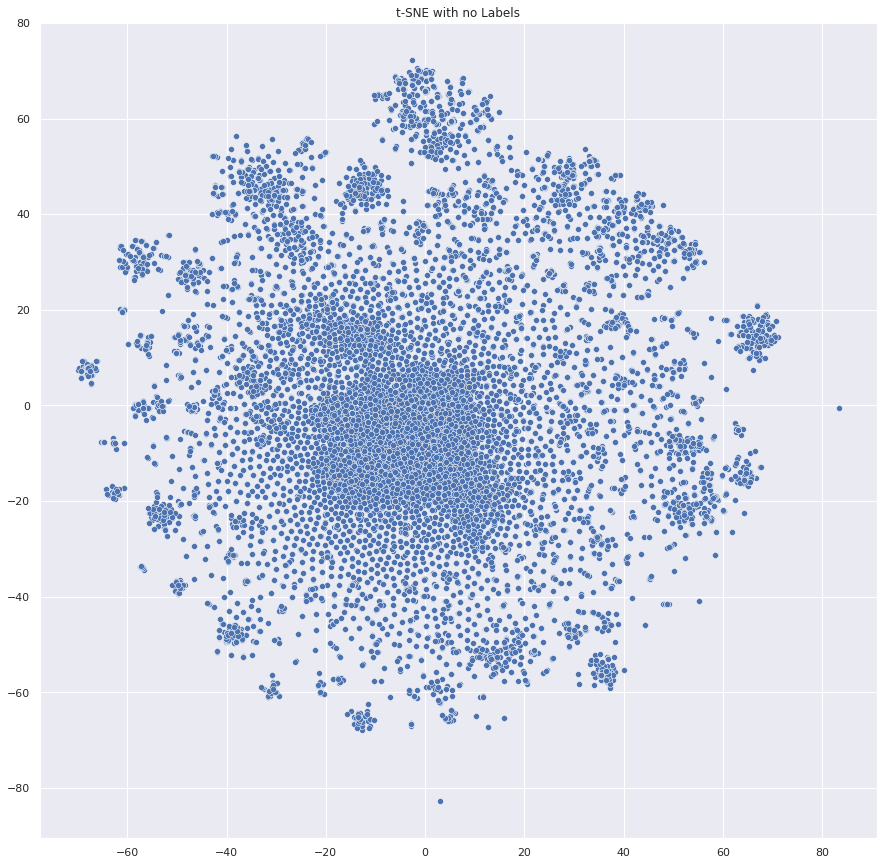

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_articles.png")
plt.show()

t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

## The labeled plot gives better insight into how the articles are grouped. 

Each point represnt an article. The distance between the articles shoes the similarity of the content. Color of the articles represnt cluster/group to which they belong to

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


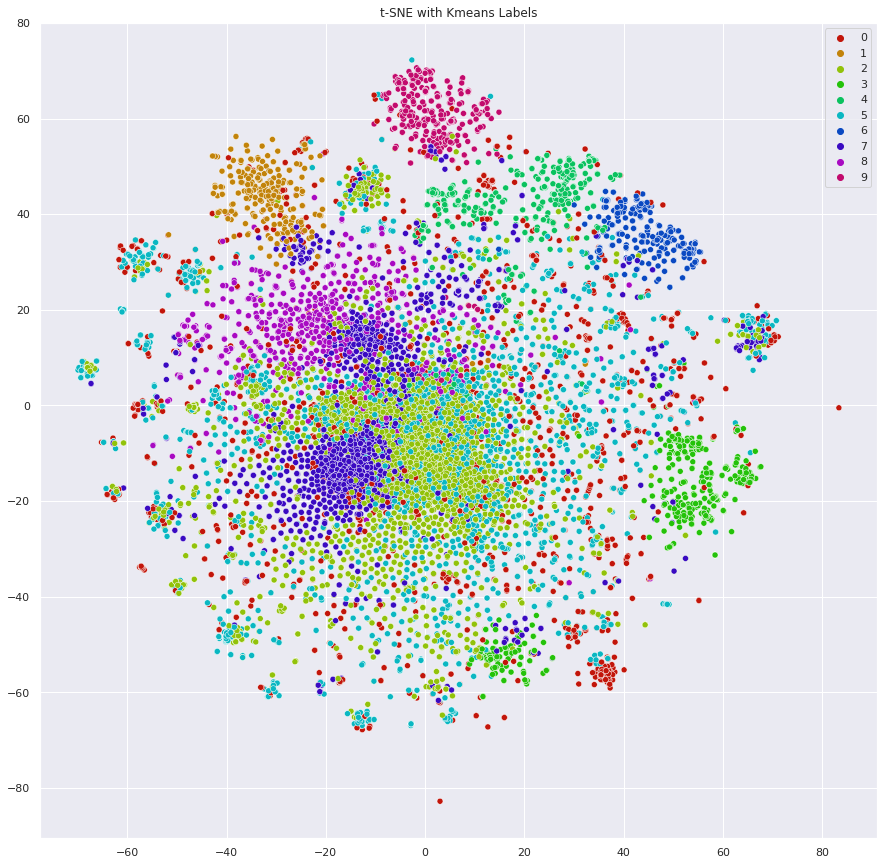

In [ ]:
# This  will show all the similar documents categorised with same color
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(10, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

## Topic Modeling on Each Cluster

Now we will try to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

*For topic modeling, I will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.*

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First I will create 10 vectorizers, one for each of our cluster labels

In [ ]:
vectorizers = []
    
for ii in range(0, 10):
    # What kind of words are used in the corpus, and how many times it is used in entire corpus.
    # I used count vectorizer to calculate the term frequencies.
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, 
                                       stop_words=stopwords,
                                       token_pattern='[a-zA-ZäöüÄÖÜß][a-zA-ZäöüÄÖÜß]{2,}',
                                       lowercase=True))

Now vectorize the data from each of our clusters

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10
lda_models = []
for ii in range(0, 10):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

For each cluster,I have created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    #print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

### Every Group has these most significant words

In [ ]:
from pprint import pprint
n = 0
for words in all_keywords:
  print(f"Category {n} : {words} ")
  n= n+1

Category 0 : ['tel', 'uhr', 'straße', 'internet', 'waffen', 'theater', 'tag', 'bonn', 'darknet', 'color', 'bild', 'dienstag', 'tatort', 'miesbach', 'name', 'starnberg', 'forum', 'tschiller', 'jugendlich', 'landgericht', 'libori', 'dom', 'biergarten', 'sexuell', 'würzburg', 'justizminister', 'cdu', 'sessions'] 
Category 1 : ['schein', 'falsch', 'angeklagt', 'schäfer', 'polizei', 'bka', 'jahr', 'blüten', 'lka', 'gefälscht', 'beid', 'landshut', 'hamburg', 'garage', 'desue', 'schleswig', 'durchsuchungen', 'holstein', 'fälschungen', 'prozent'] 
Category 2 : ['daten', 'bitcoin', 'tor', 'internet', 'täter', 'drogen', 'menschen', 'kinder', 'all', 'polizei', 'jed', 'tatort', 'kokain', 'bilder', 'sexuell', 'angeklagt', 'euro', 'maizi', 'welt', 'münchen', 'folgen', 'spd', 'richter', 'langdon', 'unternehmen', 'kpmg'] 
Category 3 : ['amoklauf', 'pistole', 'mutmaßlich', 'menschen', 'täter', 'münchen', 'plattform', 'tötung', 'münchner', 'waffen', 'sonboly', 'rico', 'november', 'philipp', 'ali', 'foru

In [ ]:
## Adding these tag to the dataset for future use.
symbol_sector = {
    0: ', '.join(all_keywords[0]),
    1: ', '.join(all_keywords[1]),
    2: ', '.join(all_keywords[2]),
    3: ', '.join(all_keywords[3]),
    4: ', '.join(all_keywords[4]),
    5: ', '.join(all_keywords[5]),
    6: ', '.join(all_keywords[6]),
    7: ', '.join(all_keywords[7]),
    8: ', '.join(all_keywords[8]),
    9: ', '.join(all_keywords[9])
}

df['tag'] = df['y'].map(symbol_sector)
   

In [ ]:
df.to_csv('out_26nov.csv', index=False)

##  Extractive summary of each group 

Now we have 10 different categories of articles and the tags. Some  group contain 1000 articles, some 3000+ some just 500. It depends upon the content. Now we will extract the summaries for each group.

I tried one Frequency method. The basic idea for creating a summary of any document includes the following:
- Frequency table of words/Word Frequency Distribution – how many times each word appears in the document
- Score each sentence depending on the words it contains and the frequency table
- Build summary by joining every sentence above a certain score limit

In [ ]:
import spacy
import numpy as np
import pandas as pd
from string import punctuation
from nltk.corpus import stopwords
from string import punctuation
import re
import nltk
nltk.download('stopwords')
!python -m spacy download de_core_news_sm
import de_core_news_sm
nlp = spacy.load('de_core_news_sm')
nlp.max_length = 4500000
                 

In [ ]:
df_list = []
for cat in range(0,9):
  df_list.append(df.loc[df['y'] == cat])

df_list[1]


In [ ]:
# Created couple of functions to extact the summary.
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 
def extract_summary(document,num):
  
  german_stop_words = stopwords.words('german')
  docx = nlp(document)
  # Tokenization of Text
  mytokens = [token.text for token in docx]
  #WORD FREQUENCY TABLE
  word_frequencies = {}
  for word in docx:
      if word.text not in german_stop_words:
              if word.text not in word_frequencies.keys():
                  word_frequencies[word.text] = 1
              else:
                  word_frequencies[word.text] += 1
  #MAXIMUM WORD FREQUENCY
  maximum_frequency = max(word_frequencies.values())
  for word in word_frequencies.keys():  
          word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
  # SENTENCE SCORE AND RANKING OF WORDS IN EACH SENTENCE
  sentence_list = [ sentence for sentence in docx.sents ]
  # Sentence Score via comparrng each word with sentence
  sentence_scores = {}  
  for sent in sentence_list:  
          for word in sent:
              if word.text.lower() in word_frequencies.keys():
                  if len(sent.text.split(' ')) < 30:
                      if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word.text.lower()]
                      else:
                          sentence_scores[sent] += word_frequencies[word.text.lower()]
  #FINDING TOP N SENTENCE WITH LARGEST SCORE
  sentence_list = [ sentence for sentence in docx.sents ]
  # Sentence Score via comparrng each word with sentence
  sentence_scores = {}  
  for sent in sentence_list:  
          for word in sent:
              if word.text.lower() in word_frequencies.keys():
                  if len(sent.text.split(' ')) < 30:
                      if sent not in sentence_scores.keys():
                          sentence_scores[sent] = word_frequencies[word.text.lower()]
                      else:
                          sentence_scores[sent] += word_frequencies[word.text.lower()]
  #FINDING TOP N SENTENCE WITH LARGEST SCORE
  from heapq import nlargest
  summarized_sentences = nlargest(num, sentence_scores, key=sentence_scores.get)
  final_sentences = [ w.text for w in summarized_sentences ]
  summary = ' '.join(final_sentences)
  summary=re.sub('[^a-zA-Z0-9äöüÄÖÜß.]+', ' ', summary)

  return summary

In [ ]:
#extracting summary for first category 
from nltk.corpus import stopwords
extractive_summary= []
for cat in range(0,9):
  print(f'Currently processing category :{cat}')
  print(f'It has {len(df_list[cat].text)} documents')
  summary = []  
  for document in df_list[cat].text: 
    #document=re.sub('[^a-zA-ZäöüÄÖÜß]+', ' ', document) 
    summary.append(extract_summary(document,3))
  s = listToString(summary)
  extractive_summary.append(extract_summary(s,3))
  print(extractive_summary[cat])

In [ ]:
 df_list.append(df.loc[df['y'] == 9])
for document in df_list[9].text: 
  #document=re.sub('[^a-zA-ZäöüÄÖÜß]+', ' ', document) 
  summary.append(extract_summary(document,3))
s = listToString(summary)
extractive_summary.append(extract_summary(s,3))
print(extractive_summary[9])

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

my_list = df_list[0].tag
#fig, ax = plt.subplots(rows, cols, figsize=(12.5,6.5))
unique_string=(" ").join(my_list)
wordcloud = WordCloud(background_color='white',mode="RGB", width=2000 , height=1000).generate(unique_string) 
plt.figure(figsize=(6,4))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

## Saving the output into the csv for tuture use and to show in another program

In [ ]:
df.drop(columns=['extractive_summary'])

In [ ]:
symbol_sector = {
    0: extractive_summary[0],
    1: extractive_summary[1],
    2: extractive_summary[2],
    3: extractive_summary[3],
    4: extractive_summary[4],
    5: extractive_summary[5],
    6: extractive_summary[6],
    7: extractive_summary[7],
    8: extractive_summary[8],
    9: extractive_summary[9]
}
df['extractive_summary']= df['y'].map(symbol_sector)

In [ ]:
df.to_csv('out_27nov.csv', index=False)

## The extractive summaries and Tags is displayed in next notebook